In [1]:
import matplotlib.pyplot as plt;
import numpy as np;
from scipy.constants import c;
from scipy.interpolate import interp1d;
from scipy.signal import find_peaks;
from importlib import reload as rel;
import sys; 
#sys.path.insert(0, "..\\..\\python\\"); # Windows
sys.path.insert(0, "../../python"); # Ubuntu
sys.path.insert(0, "../current_profiles/")
from crystal import crystal
import current_profiles as cp;
from ebeam import ebeam;
from laser import laser;
from plotting import makefig;
import phase_retard as pr;
import thz;

In [2]:
def plot_gammas(gs, ts, snames, save = False):

    fig1, ax1 = makefig(x = 8, y = 6, xlab = 't [ps]', ylab = r'$\Gamma$', title = 'Phase');
    fig2, ax2 = makefig(x = 8, y = 6, xlab = 't [ps]', ylab = r'sin($\Gamma$)', title = 'Balanced detectors');
    fig3, ax3 = makefig(x = 8, y = 6, xlab = 't [ps]', ylab = r'sin$^2(\Gamma / 2)$', title = 'Crossed polarizers');
    
    
    ax1.plot(ts[0] * 1e12, gs[0], label = 'Combined');
    ax1.plot(ts[1] * 1e12, gs[1], '--',  label = 'Drive');
    ax1.plot(ts[2] * 1e12, gs[2], '-.', label = 'Witness');
    
    ax2.plot(ts[0] * 1e12, np.sin(gs[0]), label = 'Combined');
    ax2.plot(ts[1] * 1e12, np.sin(gs[1]), '--',  label = 'Drive');
    ax2.plot(ts[2] * 1e12, np.sin(gs[2]), '-.', label = 'Witness');
    
    ax3.plot(ts[0] * 1e12, np.sin(gs[0] / 2)**2, label = 'Combined');
    ax3.plot(ts[1] * 1e12, np.sin(gs[1] / 2)**2, '--',  label = 'Drive');
    ax3.plot(ts[2] * 1e12, np.sin(gs[2] / 2)**2, '-.', label = 'Witness');
    
    ax1.legend();
    ax2.legend();
    ax3.legend();
    
    if save:
        fig1.savefig(snames[0])
        fig2.savefig(snames[1])
        fig3.savefig(snames[2])
    plt.show();
def get_gammas(dx, psi):
    print("Combined")
    gamma, t_gamma = pr.phase_retard(Ec, tt*1e-12, d_arr, [], probe, cry, 'spatial', delta_x = dx, \
                                     nx = 1000, psi = psi);
    print("Drive")
    g_drive, t_drive = pr.phase_retard(Ec_drive, tt*1e-12, d_arr, [], probe, cry, 'spatial', delta_x = dx, \
                                     nx = 1000, psi = psi);
    print("Witness")
    g_wit, t_wit = pr.phase_retard(Ec_wit, tt*1e-12, d_arr, [], probe, cry, 'spatial', delta_x = dx, \
                                     nx = 1000, psi = psi);
    return (gamma, g_drive, g_wit), (t_gamma, t_drive, t_wit);

In [3]:
# Bunch parameters:
sigz    = 5.2e-6;
sigt    = sigz / c;
dt      = sigt / 10;
N       = 8000;
t       = np.linspace(-N * dt / 2, N * dt / 2, N);
Q_drive = 1.5e-9;
Q_wit   = 0.5e-9;
z_off   = 150e-6;
r0      = 5e-3;
drive   = ebeam({'Q' : Q_drive, 't' : t, 'sigz' : sigz, 'r0' : r0, 'del_z' : 0});
wit     = ebeam({'Q' : Q_wit, 't' : t, 'sigz' : sigz, 'r0' : r0, 'del_z' : z_off});
#Er      = drive.Er + wit.Er;
# Initialize crystals and their parameters
cry = crystal('gap');
d    = 50e-6; # m
nslice = 100;
j     = np.arange(1, nslice, 1);
dz    = d / nslice;
d_arr = (j - 0.5) * dz;
# Initialize probe
y0 = 800e-9; 
dy = 27e-9;
tp = 30e-15;
probe = laser({'y0' : y0, 'dy' : dy, 'tp' : tp});

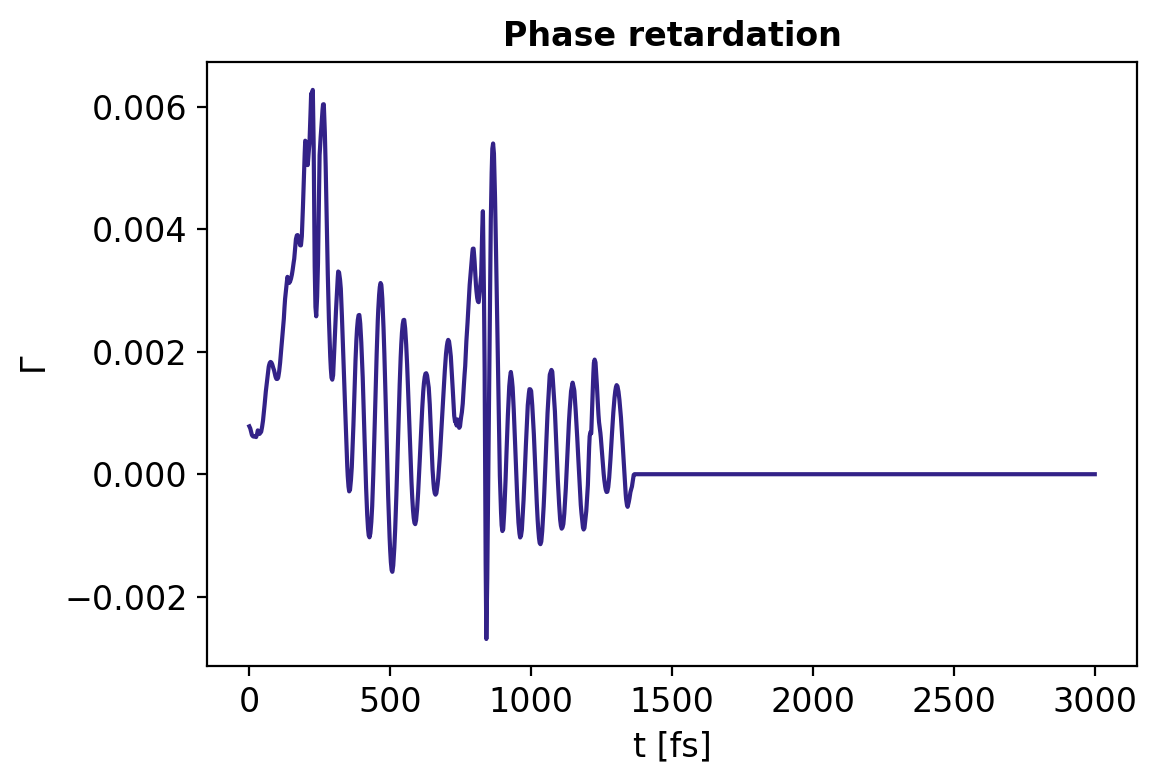

In [6]:
I, ti, z, dz, dt = cp.get_current(0);
E, ze, te = cp.get_E(I, ti, z, 5e-3);
E = np.flip(E, axis = 0);
te = te - te[np.argmax(E)];
f_E_int = interp1d(te, E)
te_int  = np.linspace(te[0], -te[0], 1000);
E_int   = f_E_int(te_int)
FEr, f = thz.raw_field(E_int, te_int);
Ec, tt = thz.cry_field(te_int, FEr, f, d, probe, cry, nslice = nslice);
tau = np.linspace(0, 3000, 1000) * 1e-15
gamma, t_gamma = pr.phase_retard(Ec, tt*1e-12, d_arr, tau, probe, cry, 'spatial', psi = 15 * np.pi / 180, plot = True)

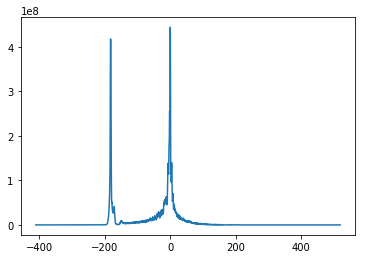

In [25]:
plt.plot(te * c * 1e6, E)
plt.show()

In [12]:
max_ind = np.argmax(E)

In [14]:
min_ind = np.argmax(E[0:int(max_ind/2)])

In [15]:
te[max_ind]

0.0

In [23]:
abs(te[max_ind] - te[min_ind]) * 1e12

0.6852586021786906

In [4]:
FEr_drive, f = thz.raw_field(drive.Er, drive.t);
FEr_wit, f   = thz.raw_field(wit.Er, wit.t);
FEr, f = thz.raw_field(Er, drive.t);
#Ec_drive, Ec_wit, Ec, tt = thz.cry_two_field(drive.t,FEr_drive, FEr_wit, FEr, f, d, probe, cry, nslice = nslice);

In [5]:
depths      = np.array([50, 100, 150, 200]) * 1e-6;
angles      = np.array([5, 10, 15, 20, 25, 30]) * np.pi / 180;
tau         = np.linspace(0, 3000, 1000) * 1e-15;
gamma       = np.zeros((10000, len(depths), len(angles)));
gamma_drive = np.zeros((10000, len(depths), len(angles)));
gamma_wit   = np.zeros((10000, len(depths), len(angles)));

In [6]:
for i in range(len(depths)):
    print(i+1, "of", len(depths))
    d     = depths[i];
    k     = np.arange(1, nslice, 1);
    dz    = d / nslice;
    d_arr = (k - 0.5) * dz;
    Ec_drive, Ec_wit, Ec, tt = thz.cry_two_field(drive.t,FEr_drive, FEr_wit, FEr, f, d, probe, cry, nslice = nslice);
    for j in range(len(angles)):
        g, dummy = pr.phase_retard(Ec, tt*1e-12, d_arr, tau, probe, cry, 'spatial', psi = angles[j]);
        g_drive, dummy = pr.phase_retard(Ec_drive, tt*1e-12, d_arr, tau, probe, cry, 'spatial', psi = angles[j]);
        g_wit, dummy = pr.phase_retard(Ec_wit, tt*1e-12, d_arr, tau, probe, cry, 'spatial', psi = angles[j]);
        gamma[:, i, j] = g;
        gamma_drive[:, i, j] = g_drive;
        gamma_wit[:, i, j] = g_wit;

1 of 4
2 of 4
3 of 4
4 of 4


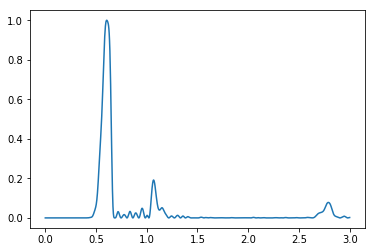

In [7]:
#%matplotlib tk
depth_ind = 1; angle_ind = 2;
sig = np.sin(gamma[:, depth_ind, angle_ind] / 2)**2;
sig = sig / max(sig)
plt.plot(dummy*1e12, sig)
plt.show()
#ind = find_peaks(sig, height = 0.05)[0]
#print(sig[ind])
#print(dummy[ind] * 1e12)
#print(depths[depth_ind]*1e6, angles[angle_ind] * 180 / np.pi)

In [100]:
fig, ax = makefig(x = 8, y = 6, xlab = r'$\psi$ [deg.]', ylab = 'S / N', title = 'Witness signal to noise')
sn_50 = [1.64, 3.02, 1.6, 2.33, 2.64, 3.43];
sn_100 = [8.26, 6.64, 6.84, 3.52, 3.5, 2.21];
sn_150 = [6.17, 3.9, 2.77, 4.17, 2.76, 1.82];
sn_200 = [8.67, 2.74, 4.54, 2.39, 1.45, 1.11];
sn = (sn_50, sn_100, sn_150, sn_200);
for i in range(len(depths)):
    label = 'd =' + str(np.round(depths[i] * 1e6, 0)) + r'$\mu$m';
    ax.plot(angles * 180 / np.pi, sn[i], 'o', label = label)
ax.legend();
plt.show()